In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
pd.set_option("display.precision", 2)

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = 12, 8

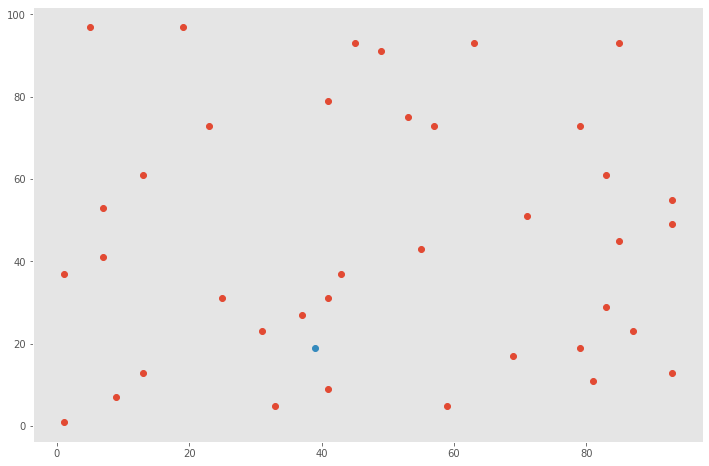

In [26]:
class Model:
    def __init__(self,input_address):
        self.m, self.cap, self.data = self.preprocess(input_address)
        
    
    def plot(self,data):
        plt.plot(data[0,1],data[0,2], 'o')
        plt.plot(data[1:,1],data[1:,2], 'o')
        plt.grid(False)
        
    @staticmethod
    def preprocess(input_address):
        data = []
        with open(input_address, 'r') as f:
            for i, row in enumerate(f.readlines()):
                if i == 0:
                    temp = [int(x) for x in row.split(' ') if x != '' and x != '\n']
                    m, cap = temp[0],temp[1]
                else:
                    data.append([int(x) for x in row.split(' ') if x != '' and x != '\n'])
        return m,cap,np.array(data)

    
            
model = Model('data.txt')